In [1]:
#directories and libraries
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-09-06 08:57:03.891728: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 08:57:03.891758: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Data Loading

Load target data, 1000 spectrograms. It is 10 genres of music, each with 100 30 second audio files. Spectrograms are visual representations of signal frequency and amplitude over time. Load spectrograms organized by class label into training and validation test sets.

In [2]:
# load dataset from directory with Keras .image_dataset_from_directory
#folders need to be labeled as classes, files need to be jpg,png,bmp,gif

BATCH_SIZE = 32 #32 by default
IMG_HGT = 288 #pixels tall
IMG_WID = 432 # pixels wide

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory= 'data',                                        
    labels='inferred', #folder names for labels
    batch_size = BATCH_SIZE,
    validation_split=0.1, #percentage to leave for validation
    shuffle = True, #sorts in alphanumeric order if false
    color_mode='rgb', #determines if image has 1,3,4 channels
    image_size=(IMG_HGT, IMG_WID),
    subset = 'training',
    seed=1                                  
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory= 'data',                                        
    labels='inferred', #folder names for labels
    batch_size = BATCH_SIZE,
    validation_split=0.1, #percentage to leave for validation
    shuffle = True, #sorts in alphanumeric order if false
    color_mode='rgb', #determines if image has 1,3,4 channels
    image_size=(IMG_HGT, IMG_WID),
    subset = 'validation',
    seed=1    )

Found 999 files belonging to 10 classes.
Using 900 files for training.


2022-09-06 08:57:07.755027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-06 08:57:07.755054: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-06 08:57:07.755070: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jtaz-VirtualBox): /proc/driver/nvidia/version does not exist
2022-09-06 08:57:07.756322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 999 files belonging to 10 classes.
Using 99 files for validation.


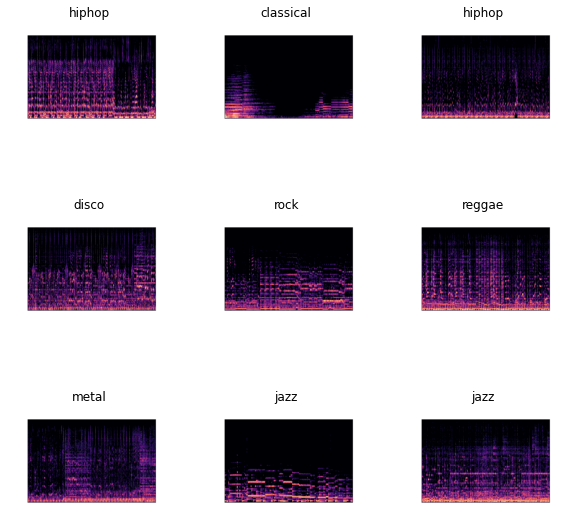

In [3]:
#tensorflow.org/tutorials/images/classification
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

# 2. Data Preparation
Spectrograms are RGB meaning they have 3 channels of values between 0-255. These need to be scaled to 0-1. This can be done with tf.keras.layers.rescaling. I could also augment the testing dataset by flipping and rotating the images to reduce bias. However, the model is designed to recognize genres in spectograms. This assumption means augmenting the testing dataset is less likley to be helpful.

In [4]:
#tensorflow.org/tutorials/images/classification

def scale(ds):
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    #flip_rotate = tf.keras.Sequential([
    #tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    #tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    #])
    
    ds = ds.map(lambda x, y: (rescale(x),y))
    return ds

In [5]:
train_ds_norm = scale(train_dataset)
val_ds_norm = scale(val_dataset)

In [6]:
#pixel values reduced to 0-1

image_batch, labels_batch = next(iter(train_ds_norm))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


# 3. Create the Model
Keras sequential model is appropriate when each layer has one input and one output. This works well for CNN.

In [7]:
#tensorflow.org/tutorials/images/classification

num_classes = len(class_names)

model = tf.keras.models.Sequential( #instantiate model
    [
        layers.Input(shape=(IMG_HGT,IMG_WID, 3)),
        layers.Conv2D(32, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid'),
        layers.Conv2D(64, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid'),
        layers.Conv2D(128, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation = 'softmax')
    ])

# 4. Compile Model

In [8]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(), #compare Adam to RMSprop
    metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 286, 430, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 213, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 70, 106, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 68, 104, 128)      73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 34, 52, 128)     

# 5. Train Model

In [9]:
history = model.fit(train_ds_norm, epochs = 10, validation_data = val_ds_norm)

Epoch 1/10


2022-09-06 08:57:17.855674: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503726080 exceeds 10% of free system memory.
2022-09-06 08:57:23.303141: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503726080 exceeds 10% of free system memory.


 1/29 [>.............................] - ETA: 3:59 - loss: 2.3138 - accuracy: 0.0938

2022-09-06 08:57:25.024837: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503726080 exceeds 10% of free system memory.
2022-09-06 08:57:30.330997: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503726080 exceeds 10% of free system memory.


 2/29 [=>............................] - ETA: 3:09 - loss: 29.1733 - accuracy: 0.0938

2022-09-06 08:57:32.055461: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503726080 exceeds 10% of free system memory.


29/29 [==============================] - 193s 7s/step - loss: 4.2704 - accuracy: 0.1889 - val_loss: 2.3331 - val_accuracy: 0.2525
Epoch 2/10
29/29 [==============================] - 188s 6s/step - loss: 1.8223 - accuracy: 0.3511 - val_loss: 2.1843 - val_accuracy: 0.3131
Epoch 3/10
29/29 [==============================] - 189s 6s/step - loss: 1.4894 - accuracy: 0.5133 - val_loss: 2.9119 - val_accuracy: 0.2525
Epoch 4/10
29/29 [==============================] - 186s 6s/step - loss: 1.0984 - accuracy: 0.6289 - val_loss: 6.7684 - val_accuracy: 0.3333
Epoch 5/10
29/29 [==============================] - 192s 7s/step - loss: 0.8787 - accuracy: 0.7633 - val_loss: 2.0950 - val_accuracy: 0.4747
Epoch 6/10
29/29 [==============================] - 186s 6s/step - loss: 0.4028 - accuracy: 0.8722 - val_loss: 2.2110 - val_accuracy: 0.5354
Epoch 7/10
29/29 [==============================] - 191s 7s/step - loss: 0.2409 - accuracy: 0.9400 - val_loss: 1.4260 - val_accuracy: 0.5960
Epoch 8/10
29/29 [======

# 6. Change and Repeat to Improve Model Performance
overfitting seems like a major issue with test and validation accuracy 40% different. I will add a dropout layer to reduce overfitting, reduce epochs to 8 and change strides to 2 to speed up processing, and try different optimizers.

In [10]:
model2 = tf.keras.models.Sequential( #instantiate model
    [
        layers.Input(shape=(IMG_HGT,IMG_WID, 3)),
        layers.Conv2D(32, 3, strides = 2, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.Conv2D(64, 3, strides = 2, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.Conv2D(128, 3, strides = 2, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation = 'softmax')
    ])

model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(), #compare Adam to RMSprop
    metrics = ['accuracy'])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 143, 215, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 71, 107, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 35, 53, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 26, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 12, 128)        73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 6, 128)       

In [11]:
history2 = model2.fit(train_ds_norm, epochs = 8, validation_data = val_ds_norm)

Epoch 1/8
29/29 [==============================] - 27s 813ms/step - loss: 2.2639 - accuracy: 0.1456 - val_loss: 2.1611 - val_accuracy: 0.2020
Epoch 2/8
29/29 [==============================] - 23s 781ms/step - loss: 1.9991 - accuracy: 0.2533 - val_loss: 1.8054 - val_accuracy: 0.4040
Epoch 3/8
29/29 [==============================] - 23s 769ms/step - loss: 1.8018 - accuracy: 0.3367 - val_loss: 1.9213 - val_accuracy: 0.2525
Epoch 4/8
29/29 [==============================] - 23s 767ms/step - loss: 1.6831 - accuracy: 0.3967 - val_loss: 1.7013 - val_accuracy: 0.3838
Epoch 5/8
29/29 [==============================] - 23s 767ms/step - loss: 1.5190 - accuracy: 0.4567 - val_loss: 1.4743 - val_accuracy: 0.4848
Epoch 6/8
29/29 [==============================] - 23s 773ms/step - loss: 1.4357 - accuracy: 0.4700 - val_loss: 1.4704 - val_accuracy: 0.4343
Epoch 7/8
29/29 [==============================] - 23s 771ms/step - loss: 1.3608 - accuracy: 0.5178 - val_loss: 1.7847 - val_accuracy: 0.3333
Epoch 

In [12]:
model3 = tf.keras.models.Sequential( #instantiate model
    [
        layers.Input(shape=(IMG_HGT,IMG_WID, 3)),
        layers.Conv2D(32, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.Conv2D(64, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.Conv2D(128, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation = 'softmax')
    ])

model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(), #compare Adam to RMSprop
    metrics = ['accuracy'])

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 286, 430, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 143, 215, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 141, 213, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 70, 106, 64)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 68, 104, 128)      73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 34, 52, 128)     

In [13]:
history3 = model3.fit(train_ds_norm, epochs = 12, validation_data = val_ds_norm)

Epoch 1/12
29/29 [==============================] - 182s 6s/step - loss: 3.6061 - accuracy: 0.1611 - val_loss: 2.1859 - val_accuracy: 0.2121
Epoch 2/12
29/29 [==============================] - 182s 6s/step - loss: 1.9507 - accuracy: 0.2978 - val_loss: 1.5817 - val_accuracy: 0.4242
Epoch 3/12
29/29 [==============================] - 180s 6s/step - loss: 1.5219 - accuracy: 0.4822 - val_loss: 1.5604 - val_accuracy: 0.4040
Epoch 4/12
29/29 [==============================] - 187s 6s/step - loss: 1.1978 - accuracy: 0.5978 - val_loss: 1.1396 - val_accuracy: 0.6364
Epoch 5/12
29/29 [==============================] - 183s 6s/step - loss: 0.8720 - accuracy: 0.7067 - val_loss: 1.2119 - val_accuracy: 0.6162
Epoch 6/12
29/29 [==============================] - 186s 6s/step - loss: 0.6133 - accuracy: 0.7944 - val_loss: 1.1266 - val_accuracy: 0.6465
Epoch 7/12
29/29 [==============================] - 182s 6s/step - loss: 0.4121 - accuracy: 0.8622 - val_loss: 1.2818 - val_accuracy: 0.6364
Epoch 8/12
29

In [14]:
model4 = tf.keras.models.Sequential( #instantiate model
    [
        layers.Input(shape=(IMG_HGT,IMG_WID, 3)),
        layers.Conv2D(16, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.Conv2D(32, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.Conv2D(64, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.Conv2D(128, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation = 'softmax')
    ])

model4.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(), #compare Adam to RMSprop
    metrics = ['accuracy'])

model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 286, 430, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 143, 215, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 141, 213, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 70, 106, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 68, 104, 64)       18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 34, 52, 64)      

In [15]:
history4 = model4.fit(train_ds_norm, epochs = 10, validation_data = val_ds_norm)

Epoch 1/10
29/29 [==============================] - 103s 4s/step - loss: 2.4815 - accuracy: 0.1056 - val_loss: 2.2516 - val_accuracy: 0.2323
Epoch 2/10
29/29 [==============================] - 102s 3s/step - loss: 2.1556 - accuracy: 0.2078 - val_loss: 2.1669 - val_accuracy: 0.1919
Epoch 3/10
29/29 [==============================] - 103s 4s/step - loss: 2.0657 - accuracy: 0.2478 - val_loss: 1.7455 - val_accuracy: 0.3838
Epoch 4/10
29/29 [==============================] - 101s 3s/step - loss: 1.7652 - accuracy: 0.3778 - val_loss: 1.5574 - val_accuracy: 0.4444
Epoch 5/10
29/29 [==============================] - 103s 4s/step - loss: 1.5569 - accuracy: 0.4544 - val_loss: 1.5105 - val_accuracy: 0.4444
Epoch 6/10
29/29 [==============================] - 101s 3s/step - loss: 1.3661 - accuracy: 0.5278 - val_loss: 1.3126 - val_accuracy: 0.5455
Epoch 7/10
29/29 [==============================] - 101s 3s/step - loss: 1.1797 - accuracy: 0.5744 - val_loss: 1.3399 - val_accuracy: 0.5455
Epoch 8/10
29

In [20]:
model6 = tf.keras.models.Sequential( #instantiate model
    [
        layers.Input(shape=(IMG_HGT,IMG_WID, 3)),
        layers.Conv2D(32, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, strides = 1, padding = 'valid', activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation = 'softmax')
    ])

model6.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(), #compare Adam to RMSprop
    metrics = ['accuracy'])

model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 286, 430, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 286, 430, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 143, 215, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 143, 215, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          (None, 141, 213, 64)      18496     
                                                      

In [21]:
history6 = model6.fit(train_ds_norm, epochs = 10, validation_data = val_ds_norm)

Epoch 1/10
29/29 [==============================] - 253s 9s/step - loss: 1.9037 - accuracy: 0.3878 - val_loss: 3.7919 - val_accuracy: 0.0303
Epoch 2/10
29/29 [==============================] - 262s 9s/step - loss: 0.8614 - accuracy: 0.7267 - val_loss: 5.0859 - val_accuracy: 0.1515
Epoch 3/10
29/29 [==============================] - 250s 9s/step - loss: 0.3732 - accuracy: 0.9000 - val_loss: 4.2999 - val_accuracy: 0.0909
Epoch 4/10
29/29 [==============================] - 251s 9s/step - loss: 0.1795 - accuracy: 0.9711 - val_loss: 5.0622 - val_accuracy: 0.1313
Epoch 5/10
29/29 [==============================] - 248s 9s/step - loss: 0.1406 - accuracy: 0.9822 - val_loss: 5.1446 - val_accuracy: 0.1212
Epoch 6/10
29/29 [==============================] - 247s 9s/step - loss: 0.0915 - accuracy: 0.9900 - val_loss: 6.6855 - val_accuracy: 0.0909
Epoch 7/10
29/29 [==============================] - 246s 8s/step - loss: 0.1113 - accuracy: 0.9911 - val_loss: 9.0418 - val_accuracy: 0.1212
Epoch 8/10
29

# 7. Evaluate with Visualizations

## Model 1

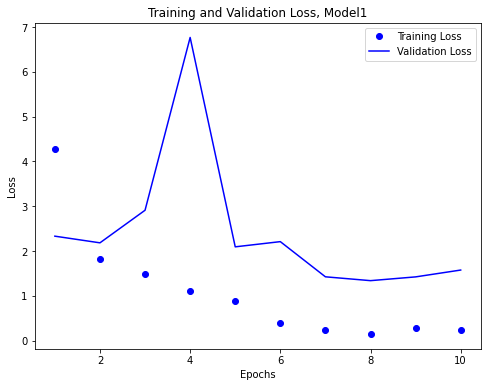

In [16]:
# loss curves for training and validation
history_dict = history.history
loss_vals = history_dict['loss']
val_loss_vals = history_dict['val_loss']
epochs = range(1, len(loss_vals)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_vals, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_vals, 'b', label='Validation Loss')
plt.title('Training and Validation Loss, Model1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

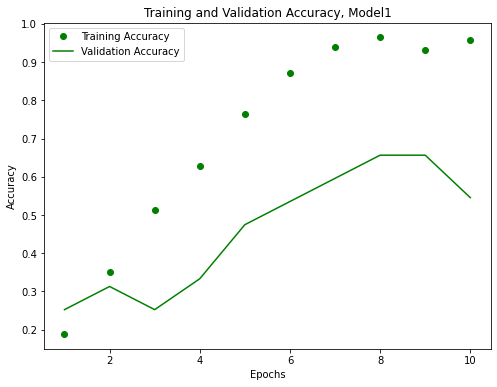

In [17]:
#plot accuracy curves
acc_vals = history_dict['accuracy']
val_acc_vals = history_dict['val_accuracy']
epochs = range(1, len(loss_vals)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_vals, 'go', label='Training Accuracy')
plt.plot(epochs, val_acc_vals, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy, Model1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model 3

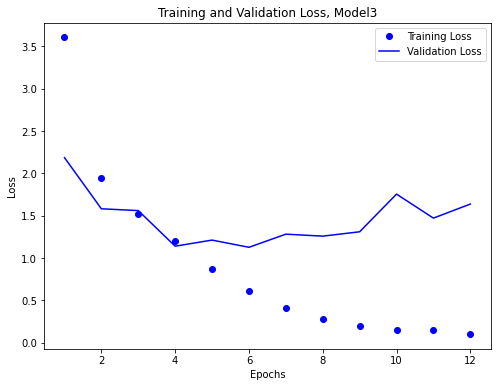

In [18]:
# loss curves for training and validation
history_dict3 = history3.history
loss_vals3 = history_dict3['loss']
val_loss_vals3 = history_dict3['val_loss']
epochs = range(1, len(loss_vals3)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_vals3, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_vals3, 'b', label='Validation Loss')
plt.title('Training and Validation Loss, Model3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

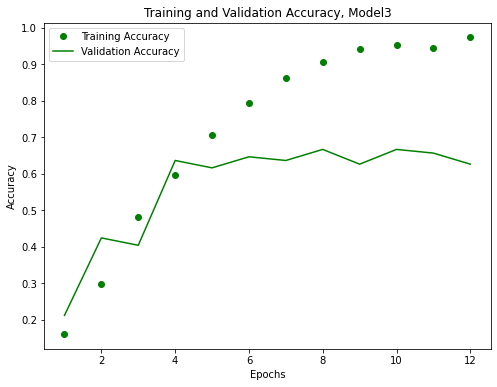

In [19]:
#plot accuracy curves
acc_vals3 = history_dict3['accuracy']
val_acc_vals3 = history_dict3['val_accuracy']
epochs = range(1, len(loss_vals3)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_vals3, 'go', label='Training Accuracy')
plt.plot(epochs, val_acc_vals3, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy, Model3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()